# Analyse BlueSeis BSPF Events

With pressure sensor parascientific and new sensor 

In [29]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__savefig import __savefig
from obspy.clients.fdsn import Client

## Configurations

In [12]:
config = {}

config['minlatitude'] = 32.444
config['maxlatitude'] = 34.8286
config['minlongitude'] = -118.652
config['maxlongitude'] = -114.941

config['BSPF_lon'] = np.array([-116.455439])
config['BSPF_lat'] = np.array([33.610643])

config['minmagnitude'] = 2.5

config['tbeg'] = obs.UTCDateTime("2022-10-01")
config['tend'] = obs.UTCDateTime("2023-01-13")

config['eventfile'] = "BSPF_event_catalog.pkl"

config['outpath'] = "./"

In [ ]:
def __export_new_events(config, events_old, events):
    
    ## combine new and old catalog
    tmp = pd.concat([__cat_to_df(events_old), __cat_to_df(events)]).reset_index(drop=False)
    ## remove duplicates
    df = tmp.drop_duplicates(subset=['index'], keep=False)
    ## sort and set index
    df = df.sort_index(ascending=False)
    df.set_index('index', inplace=True, drop=True)
    
    ## export new events to pickle file
    print(f" -> export new events: {config['outpath']}new_events.pkl")
    df.to_pickle(config['outpath']+"new_events.pkl")
    
    del tmp, df  

In [3]:
def __cat_to_df(cat):
    
    from pandas import DataFrame
    
    times = []
    lats = []
    lons = []
    deps = []
    magnitudes = []
    magnitudestype = []
    
    for event in cat:
        if len(event.origins) != 0 and len(event.magnitudes) != 0:
            times.append(event.origins[0].time.datetime)
            lats.append(event.origins[0].latitude)
            lons.append(event.origins[0].longitude)
            deps.append(event.origins[0].depth)
            magnitudes.append(event.magnitudes[0].mag)
            magnitudestype.append(event.magnitudes[0].magnitude_type )
            
    df = DataFrame({'latitude':lats,'longitude':lons,'depth':deps,
                    'magnitude':magnitudes,'type':magnitudestype}, 
                     index = times
                  )
    
    return df

In [79]:
client = Client("USGS")

events = client.get_events(minlatitude=config['minlatitude'], maxlatitude=config['maxlatitude'],
                           minlongitude=config['minlongitude'], maxlongitude=config['maxlongitude'],
                           starttime=config['tbeg'],
                           endtime=config['tend'],
                           minmagnitude=config['minmagnitude'],
                          )

# events.plot(projection="local");

# events.write(config['outpath']+"events.xml", format="QUAKEML")

[Event:	2023-01-11T18:59:20.030000Z | +33.700, -116.761 | 3.23 ml | manual

	            resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/fdsnws/event/1/query?eventid=ci40401704&format=quakeml")
	             event_type: 'earthquake'
	          creation_info: CreationInfo(agency_id='ci', creation_time=UTCDateTime(2023, 1, 12, 22, 14, 48, 230000), version='7')
	    preferred_origin_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/ci40401704/ci/1673466127970/product.xml")
	 preferred_magnitude_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/ci40401704/ci/1673466127970/product.xml#magnitude")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements,
 Event:	2023-01-09T19:42:56.460000Z | +33.396, -116.397 | 3.18 ml | manual

	            resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/fdsnws/event/1/query?eventid=ci40155015&format=qua

In [8]:
events_df = __cat_to_df(events)

events_df.to_pickle(config['outpath']+config['eventfile'])

In [27]:
def __makeplot_eventmap(config, data):
    

    import pygmt
    import pandas as pd

    
    # Set the region
    region = [config['minlongitude'], config['maxlongitude'], config['minlatitude'], config['maxlatitude']]



    fig = pygmt.Figure()
    
#     fig.basemap(region=region, projection="M15c", frame=True)


    # make color pallets
    pygmt.makecpt(
        cmap='etopo1',
        series='-8000/5010/1000',
        continuous=True
    )
    
    
    # define etopo data file
    topo_data = "@earth_relief_03s"
#     topo_data = pygmt.datasets.load_earth_relief(resolution="03s", region=region)
    
    ## adjust land and sea/lakes
#     land = topo_data * pygmt.grdlandmask(region=region, 
#                                          spacing="03s", 
#                                          maskvalues=[0, 1], 
#                                          resolution="f"
#                                         )
#     wet = topo_data * pygmt.grdlandmask(region=region, 
#                                         spacing="03s", 
#                                         maskvalues=[1, "NaN"], 
#                                         resolution="f"
#                                        )

    # plot high res topography
    fig.grdimage(
        grid=topo_data,
        region=region,
        projection='M4i',
        shading=True,
        frame=True
    )
        
    
    ## add coastlines
    fig.coast(shorelines=True, frame=False)
#     fig.coast(rivers="1/0.5p,blue") # Rivers

    
    # colorbar colormap
    pygmt.makecpt(cmap="rainbow", series=[data.depth.min(), data.depth.max()])

    
    ## plot data coordinates
    fig.plot(
        x=data.longitude,
        y=data.latitude,
        sizes=0.07*data.magnitude,
        color=data.depth,
        cmap=True,
        style="cc",
        pen="black",
    )

    ## plot PFO
    fig.plot(
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        sizes=np.array([0.3]),
        color="white",
        style="t",
        pen="black",
    )
    
    fig.text(
        text="PFO",
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        offset=[0.3,0.3],
        font="9p,Helvetica-Bold,black"
    )
    
    ## add depth colorbar
    fig.colorbar(frame='af+l"Depth (km)"')
    
    
    fig.savefig(config['outpath']+'event_map.png')

    fig.show();
    return fig

fig = __makeplot_eventmap(config, events_df)

grdblend [WARNING]: File @N30W120.earth_relief_15s_p.nc has different increments (0.00416666666667/0.00416666666667) than the output grid (0.000833333333333/0.000833333333333) - must resample
grdblend [WARNING]: File @N30W120.earth_relief_15s_p.nc coordinates are phase-shifted w.r.t. the output grid - must resample


In [ ]:
def __makeplot_eventmap_3d(config, data):
    

    import pygmt
    import pandas as pd

    
    # Set the region
    region = [config['minlongitude'], config['maxlongitude'], config['minlatitude'], config['maxlatitude']]



    fig = pygmt.Figure()
#     fig.basemap(region=region, projection="M15c", frame=True)

    # make color pallets
    pygmt.makecpt(
        cmap='etopo1',
        series='-8000/5000/1000',
        continuous=True
    )

    # define etopo data file
    topo_data = "@earth_relief_03s"

    
    fig.grdview(
        grid=topo_data,
        # Set the azimuth to -130 (230) degrees and the elevation to 30 degrees
        perspective=[-130, 30],
        frame=["xaf", "yaf", "WSnE"],
        projection="M15c",
        zsize="1.5c",
        surftype="s",
        cmap="geo",
        plane="1000+ggrey",
        # Set the contour pen thickness to "0.1p"
        contourpen="0.1p",
    )
    fig.colorbar(perspective=True, frame=["a500", "x+lElevation", "y+lm"])
    
    
#     # plot high res topography
#     fig.grdimage(
#         grid=topo_data,
#         region=region,
#         projection='M4i',
#         shading=True,
#         frame=True
#     )
    
#     fig.colorbar(perspective=True, frame=["a500", "x+lElevation", "y+lm"])
    
#     fig.coast(shorelines=True, frame=False)

#     # colorbar colormap
#     pygmt.makecpt(cmap="magma", series=[data.depth.min(), data.depth.max()])

    fig.plot(
        x=data.longitude,
        y=data.latitude,
        sizes=0.05*data.magnitude,
        color=data.depth,
        cmap=True,
        style="cc",
        pen="black",
    )

    fig.colorbar(frame='af+l"Depth (km)"')
    
    
    fig.savefig(config['outpath']+'event_map.png')

    
    fig.show()

# fig = __makeplot_eventmap_3d(config, events_df)

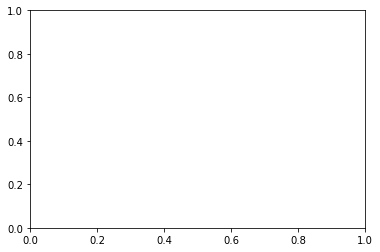

In [31]:
fig = plt.subplot()

In [36]:
__savefig(fig, outpath=config['outpath'], outname="event_map", mode="png", dpi=200)

   -> Done

